<a href="https://colab.research.google.com/github/ashwinram472/Peer-Assessment-LSTM/blob/master/peerlogic_Rnn_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp gdrive/My\ Drive/AI-In-Peer-Assessment/problems_data_3semesters_balanced_cleaned2.csv .

In [0]:
import numpy as np
# To store data
import pandas as pd

# To use regular expressions
import re

#To load and save data
import pickle

from sklearn.model_selection import train_test_split

In [0]:
reviews = pd.read_csv(r"problems_data_3semesters_balanced_cleaned2.csv")

In [0]:
data = reviews.filter(["REVIEW","TAG"])

In [0]:
data = data.loc[data.REVIEW.apply(lambda x: not isinstance(x, (float, int)))]

In [7]:

data['TAG'].value_counts()

1    9177
0    9176
Name: TAG, dtype: int64

In [0]:
train_set, test_set = train_test_split(data, test_size=0.20, random_state=42)

In [0]:
train_reviews = list(train_set["REVIEW"])
test_reviews = list(test_set["REVIEW"])

In [0]:
train_labels = list(train_set["TAG"])
test_labels = list(test_set["TAG"])

In [0]:
def preprocess(train_reviews):
    for i in range(len(train_reviews)):
        train_reviews[i] = re.sub('\d',' ',train_reviews[i]) # Replacing digits by space
        train_reviews[i] = re.sub(r'\s+[a-z][\s$]', ' ',train_reviews[i]) # Removing single characters and spaces alongside
        train_reviews[i] = re.sub(r'\s+', ' ',train_reviews[i]) # Replacing more than one space with a single space
    
    for i in range(len(train_reviews)):
        if 'www.' in train_reviews[i] or 'http:' in train_reviews[i] or 'https:' in train_reviews[i] or '.com' in train_reviews[i]:
            train_reviews[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_reviews[i])
        
        
    return train_reviews



In [0]:
train_reviews = preprocess(train_reviews)
test_reviews = preprocess(test_reviews)


In [13]:

# Use Tokenizer to remove punctuations and non-word characters and tokenize the text
import os
os.environ['KERAS_BACKEND']='tensorflow' # Or TenserFlow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
MAX_SEQUENCE_LENGTH = 280
MAX_NB_WORDS = 280 # This specifies how many top tokens in each review to be stored. Wrongly interpreted as total number of words(token) together in whole dataset
EMBEDDING_DIM = 300

In [15]:

# Takes 5 minutes to run on entire training dataset
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_reviews)
train_sequences = tokenizer.texts_to_sequences(train_reviews)

test_sequences = tokenizer.texts_to_sequences(test_reviews)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index)) # Total 996497 unique words

Number of Unique Tokens 6990


In [0]:
#Padding
train_sequences_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_sequences_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
!cp gdrive/My\ Drive/Glove/glove100d.txt .

In [0]:
!cp gdrive/My\ Drive/Glove/glove.840B.300d.txt .

In [25]:
pip install git+http://github.com/uber/ludwig.git

  Cloning http://github.com/uber/ludwig.git to /tmp/pip-req-build-7vcmggob
  Running command git clone -q http://github.com/uber/ludwig.git /tmp/pip-req-build-7vcmggob
     |████████████████████████████████| 110.5MB 43kB/s 
  Created wheel for ludwig: filename=ludwig-0.2.1-cp36-none-any.whl size=233119 sha256=5b1a137fe18471c7458dd577d9ec09952e4b2e3a47cd3470144c4ef8a738c898
  Stored in directory: /tmp/pip-ephem-wheel-cache-fl2_68o5/wheels/0d/40/9f/388f8abc1b742755cf96c43123fbd8e02bf3022611d4554e0e
Successfully built ludwig
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
embeddings_index = {}
f = open('glove.840B.300d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [24]:
# embeddings_index = {}
# for i, line in enumerate(open('glove.840B.300d.txt',encoding="utf8")):
#     values = line.split() # 0 th index will be the word and rest will the embedding vector (size 100 as we have used Glove.6B.100D embedding file) 
#     embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

ValueError: ignored

In [0]:
# create token(words in word index)-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300)) # 100 since embedding_dimesion is 100, +1 because index 0 is reserved in word_index
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / len(word_index)

0.8722460658082976

In [0]:

from sklearn.utils import shuffle
x_train, y_train = shuffle(train_sequences_padded, train_labels)
x_test, y_test = shuffle(test_sequences_padded,test_labels)
y_test1 = y_test[:]

In [30]:
x_train = np.array(x_train[:])
train_labels = [[1,0] if x == 1 else [0,1] for x in y_train[:]] 
y_train = np.array(train_labels[:])
len(x_train),len(y_train)

x_test = np.array(x_test[:])
test_labels = [[1,0] if x == 1 else [0,1] for x in y_test[:]] 
y_test = np.array(test_labels[:])
len(x_test),len(y_test)

(3671, 3671)

In [31]:

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

In [32]:
net = Dropout(0.3)(embedded_sequences)
net = Bidirectional(LSTM(200,recurrent_dropout=0.3))(net)
net = Dropout(0.3)(net)
output = Dense(2, activation = 'softmax')(net)
model = Model(inputs = sequence_input, outputs = output)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 280)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 280, 300)          2097300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 280, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               801600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 802       
Total params: 2,899,702
Trainable params: 2,899,702
Non-trainable params: 0
_______________________________________________

In [34]:
chkpt=ModelCheckpoint('expertiza_rnn_model.h5',monitor='val_acc',verbose=1,save_best_only=True)
model_history = model.fit(x_train, y_train, batch_size=254, epochs=10, validation_split=0.2,callbacks=[chkpt])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 11745 samples, validate on 2937 samples
Epoch 1/10
11745/11745 [==============================] - 58s 5ms/step - loss: 0.5036 - acc: 0.7520 - val_loss: 0.4037 - val_acc: 0.8349

Epoch 00001: val_acc improved from -inf to 0.83487, saving model to expertiza_rnn_model.h5
Epoch 2/10
11745/11745 [==============================] - 54s 5ms/step - loss: 0.3789 - acc: 0.8421 - val_loss: 0.3462 - val_acc: 0.8618

Epoch 00002: val_acc improved from 0.83487 to 0.86176, saving model to expertiza_rnn_model.h5
Epoch 3/10
11745/11745 [==============================] - 55s 5ms/step - loss: 0.3483 - acc: 0.8586 - val_loss: 0.3351 - val_acc: 0.8686

Epoch 00003: val_acc improved from 0.86176 to 0.86857, saving model to expertiza_rnn_model.h5
Epoch 4/10
11745/11745 [==============================] - 55s 5ms/step - loss: 0.3314 - acc: 0.8647 - val_loss: 0.3277 - val_acc: 0.8727

Epoch 00004: val_acc imp

In [35]:
score = model.evaluate(x_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3671/3671 [==============================] - 43s 12ms/step
Test Score: 0.334267405496245
Test Accuracy: 0.8714246797451236


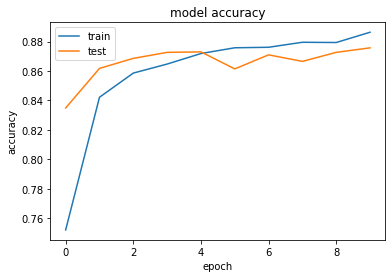

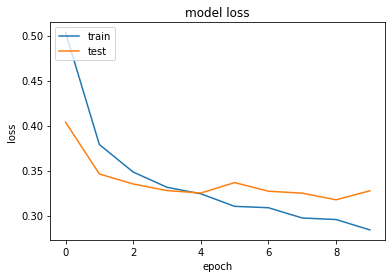

In [36]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(x_test)
y_pred = [1 if yt[0]>yt[1] else 0 for yt in y_pred1]

In [38]:

# Print f1, precision, and recall scores
print("Precision:",precision_score(y_test1, y_pred , average="macro"))
print("Recall:",recall_score(y_test1, y_pred , average="macro"))
print("F1:",f1_score(y_test1, y_pred , average="macro"))


Precision: 0.872968864270026
Recall: 0.8711893099126772
F1: 0.871234717263807


In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_input)

In [40]:
net1 = Dropout(0.3)(embedded_sequences_1)
net1 = Conv1D(50, 3, padding='same', activation='relu')(net1)
net1 = AveragePooling1D(pool_size=4)(net1)
net1 = LSTM(100, recurrent_dropout=0.3)(net1)
net1 = Dropout(0.2)(net1)
output1 = Dense(2, activation='softmax')(net1)

model5 = Model(inputs = sequence_input, outputs = output1)
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model5.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 280)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 280, 300)          2097300   
_________________________________________________________________
dropout_3 (Dropout)          (None, 280, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 50)           45050     
_________________________________________________________________
average_pooling1d_1 (Average (None, 70, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0  

In [41]:
chkpt=ModelCheckpoint('expertiza_cnn_rnn_model.h5',monitor='val_acc',verbose=1,save_best_only=True)
model_history1 = model5.fit(x_train, y_train, batch_size=100, epochs=10, validation_split=0.1,callbacks=[chkpt])

Train on 13213 samples, validate on 1469 samples
Epoch 1/10
13213/13213 [==============================] - 25s 2ms/step - loss: 0.4320 - acc: 0.8062 - val_loss: 0.3608 - val_acc: 0.8489

Epoch 00001: val_acc improved from -inf to 0.84888, saving model to expertiza_cnn_rnn_model.h5
Epoch 2/10
13213/13213 [==============================] - 18s 1ms/step - loss: 0.3305 - acc: 0.8674 - val_loss: 0.3353 - val_acc: 0.8652

Epoch 00002: val_acc improved from 0.84888 to 0.86521, saving model to expertiza_cnn_rnn_model.h5
Epoch 3/10
13213/13213 [==============================] - 18s 1ms/step - loss: 0.3193 - acc: 0.8723 - val_loss: 0.3322 - val_acc: 0.8611

Epoch 00003: val_acc did not improve from 0.86521
Epoch 4/10
13213/13213 [==============================] - 18s 1ms/step - loss: 0.3079 - acc: 0.8792 - val_loss: 0.3343 - val_acc: 0.8700

Epoch 00004: val_acc improved from 0.86521 to 0.86998, saving model to expertiza_cnn_rnn_model.h5
Epoch 5/10
13213/13213 [==============================] - 

In [0]:
model.save_weights('expertiza_rnn_model_weights.h5')

# Save the model architecture
with open('expertiza_rnn_model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [43]:
score = model5.evaluate(x_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3671/3671 [==============================] - 5s 1ms/step
Test Score: 0.3388769249359485
Test Accuracy: 0.8716970851492147


In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model5.predict(x_test)
y_pred = [1 if yt[0]>yt[1] else 0 for yt in y_pred1]

In [45]:
# Print f1, precision, and recall scores
print("Precision:",precision_score(y_test1, y_pred , average="macro"))
print("Recall:",recall_score(y_test1, y_pred , average="macro"))
print("F1:",f1_score(y_test1, y_pred , average="macro"))

Precision: 0.8729188456323843
Recall: 0.8714877772362193
F1: 0.8715409086441259
